# Imports

In [34]:
import copy
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torchvision
from torchvision import transforms 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

sys.path.append('../')
import utils

%matplotlib inline
plt.style.use('gadfly')

In [2]:
%reload_ext autoreload
%autoreload 2

# Data Exploration

In [26]:
PATH = Path('../data/hymenoptera_data/')
BATCH_SIZE = 4
EPOCHS = 10
N_CLASSES = 2
LEARNING_RATE = 1e-3

In [13]:
# Transforms
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)])
}

In [31]:
# Datasets
train_ds = ImageFolder(root=PATH / 'train', transform=data_transforms['train'])
test_ds = ImageFolder(root=PATH / 'test', transform=data_transforms['test'])

In [32]:
len(image_datasets['train'])

244

In [33]:
# Create a RandomSampler for train and validation
idxs = range(len(image_datasets['train']))
valid_pct = 0.2
train_size = int(1 - valid_pct * len(idxs))
shuffled_idxs = np.random.permutation(idxs)
train_idxs, valid_idxs = shuffled_idxs[:train_size], shuffled_idxs[train_size:]
len(train_idxs), len(valid_idxs)

(197, 47)

In [35]:
train_sampler = SubsetRandomSampler(train_idxs)
valid_sampler = SubsetRandomSampler(valid_idxs)

In [36]:
# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4)
# DataLoaders
valid_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=4)
# DataLoaders
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

In [38]:
class_names = train_ds.classes
class_names, train_ds.class_to_idx

(['ants', 'bees'], {'ants': 0, 'bees': 1})

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

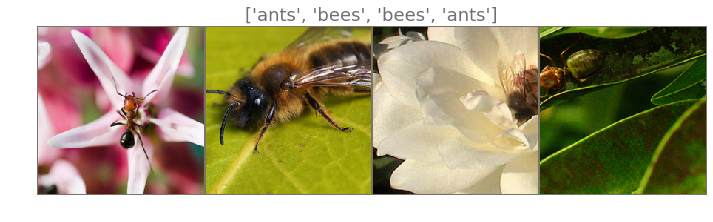

In [41]:
# Plot random images
images, labels = next(iter(train_dl))
titles = [class_names[label] for label in labels]
utils.show_images(torchvision.utils.make_grid(images), means, stds, title=titles)

# Model

In [11]:
def train_model(
    model, criterion, optimizer, data_loaders, dataset_sizes, device,
    lr_scheduler, n_epochs):
    start = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    history = {
        'loss': {'train': [], 'valid': []},
        'accuracy': {'train': [], 'valid': []}
              }

    print(f'{30 * "*":>50} Started training {30 * "*":<50}')
    for epoch in range(n_epochs):
        print(f'Epoch {(epoch + 1)}/{n_epochs}\n{10 * "-"}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_accuracy = 0

            for images, labels in data_loaders[phase]:
                images = images.to(device)
                labels = labels.to(device)
              
                # Zero grads
                optimizer.zero_grad()
                
                # Fwd pass
                with torch.set_grad_enabled(phase == 'train'):    # Set gradients on and off
                    output = model(images)
                    pred_labels = torch.argmax(output, 1)
                    
                    # Compute loss
                    loss = criterion(output, labels)

                    # Compute gradients if it's training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_accuracy += (pred_labels == labels).sum().item()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_accuracy / dataset_sizes[phase]
            print(f'{phase.capitalize():<5} Loss : {epoch_loss:.4f}, '
                  f'Accuracy : {epoch_accuracy:.2%}')

            # Deep copy best model
            if phase == 'valid'and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
            
            # Update losses and accuracies
            history['loss'][phase].append(epoch_loss)
            history['accuracy'][phase].append(epoch_accuracy)
            
        print()
    time_elapsed = time.time() - start
    print(f'Training complete in : {time_elapsed // 60}m and {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy : {best_accuracy:.2%}')
    model.load_state_dict(best_model_weights)
    
    return model, history

# Model - Redefined

# Feature Extraction

In [12]:
# Use resnet18 pretrained model as feature extractor
conv_base = torchvision.models.resnet18(pretrained=True)

# Set parameters of conv_layers to not trainable
for param in conv_base.parameters():
    param.requires_grad = False

# Add classifier on top of conv_base
n_features = conv_base.fc.in_features
conv_base.fc = nn.Linear(n_features, N_CLASSES)
conv_base = conv_base.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(conv_base.fc.parameters(),
                      lr=LEARNING_RATE, momentum=0.9)

# Define learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
model, history = train_model(
    conv_base, criterion, optimizer, image_loaders,
    dataset_sizes, device, lr_scheduler, EPOCHS
)

                    ****************************** Started training ******************************                    
Epoch 1/10
----------
Train Loss : 0.7197, Accuracy : 75.41%
Valid Loss : 0.4420, Accuracy : 86.27%

Epoch 2/10
----------
Train Loss : 0.6222, Accuracy : 80.33%
Valid Loss : 0.2682, Accuracy : 92.81%

Epoch 3/10
----------
Train Loss : 0.7063, Accuracy : 78.69%
Valid Loss : 0.2689, Accuracy : 95.42%

Epoch 4/10
----------
Train Loss : 1.1866, Accuracy : 72.13%
Valid Loss : 0.9148, Accuracy : 85.62%

Epoch 5/10
----------
Train Loss : 0.8957, Accuracy : 83.20%
Valid Loss : 0.3514, Accuracy : 91.50%

Epoch 6/10
----------
Train Loss : 0.9218, Accuracy : 79.51%
Valid Loss : 0.3256, Accuracy : 94.77%

Epoch 7/10
----------
Train Loss : 0.9958, Accuracy : 80.74%
Valid Loss : 0.2223, Accuracy : 96.08%

Epoch 8/10
----------
Train Loss : 0.7955, Accuracy : 78.69%
Valid Loss : 0.3829, Accuracy : 91.50%

Epoch 9/10
----------
Train Loss : 0.9875, Accuracy : 75.00%
Valid Loss :

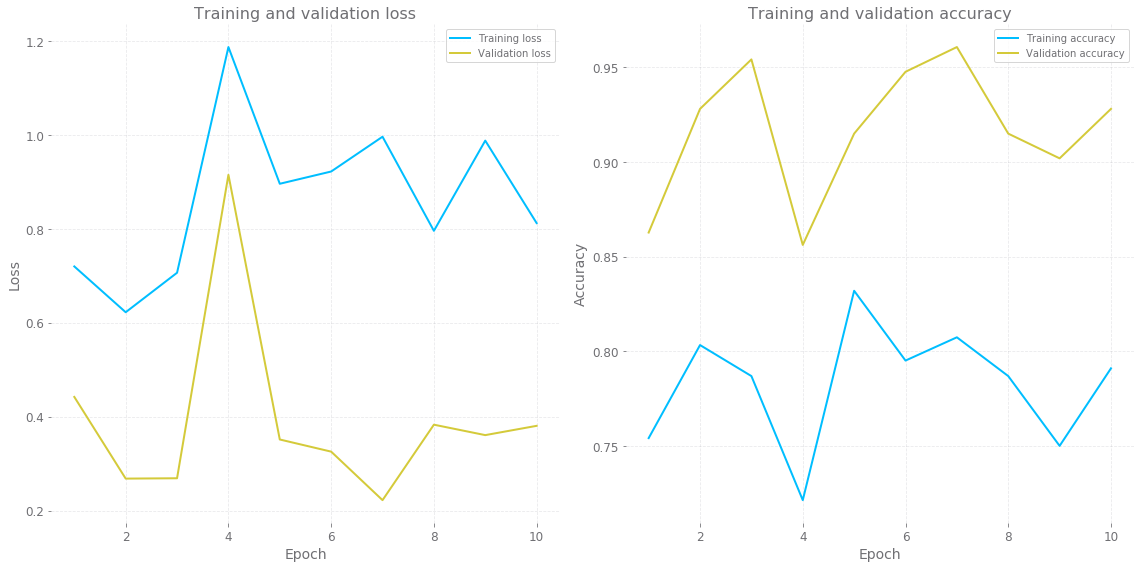

In [17]:
utils.plot_loss_and_metric(history)

# Fine Tuning 

In [18]:
# lower learning rate to avoid overshooting
LEARNING_RATE = 1e-5

We will fine tune only last layer block along with the classifier part

In [19]:
# Number of parameters for the whole NN
len([param for param in model.parameters()])

62

In [22]:
# Trainable parameters for feature extraction
len([param for param in model.parameters()
     if param.requires_grad == True])

2

In [25]:
# Parameters in layer 4
len([param for param in model.layer4.parameters()])

15

In [26]:
# Make parameters of the last block (layer 4) trainable
for param in model.layer4.parameters():
    param.requires_grad = True

len([param for param in model.parameters() if param.requires_grad])

17

In [27]:
# Optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_RATE, momentum=0.9)

In [28]:
model, history = train_model(
    model, criterion, optimizer, image_loaders,
    dataset_sizes, device, lr_scheduler, EPOCHS
)

                    ****************************** Started training ******************************                    
Epoch 1/10
----------
Train Loss : 0.8223, Accuracy : 80.74%
Valid Loss : 0.2699, Accuracy : 94.77%

Epoch 2/10
----------
Train Loss : 0.4744, Accuracy : 85.66%
Valid Loss : 0.2904, Accuracy : 94.12%

Epoch 3/10
----------
Train Loss : 0.4272, Accuracy : 87.70%
Valid Loss : 0.2853, Accuracy : 94.77%

Epoch 4/10
----------
Train Loss : 0.5748, Accuracy : 81.56%
Valid Loss : 0.2987, Accuracy : 94.12%

Epoch 5/10
----------
Train Loss : 0.4095, Accuracy : 86.07%
Valid Loss : 0.2934, Accuracy : 94.77%

Epoch 6/10
----------
Train Loss : 0.3373, Accuracy : 88.52%
Valid Loss : 0.2584, Accuracy : 92.81%

Epoch 7/10
----------
Train Loss : 0.2823, Accuracy : 90.16%
Valid Loss : 0.4232, Accuracy : 91.50%

Epoch 8/10
----------
Train Loss : 0.3374, Accuracy : 85.25%
Valid Loss : 0.2683, Accuracy : 94.77%

Epoch 9/10
----------
Train Loss : 0.3501, Accuracy : 84.43%
Valid Loss :

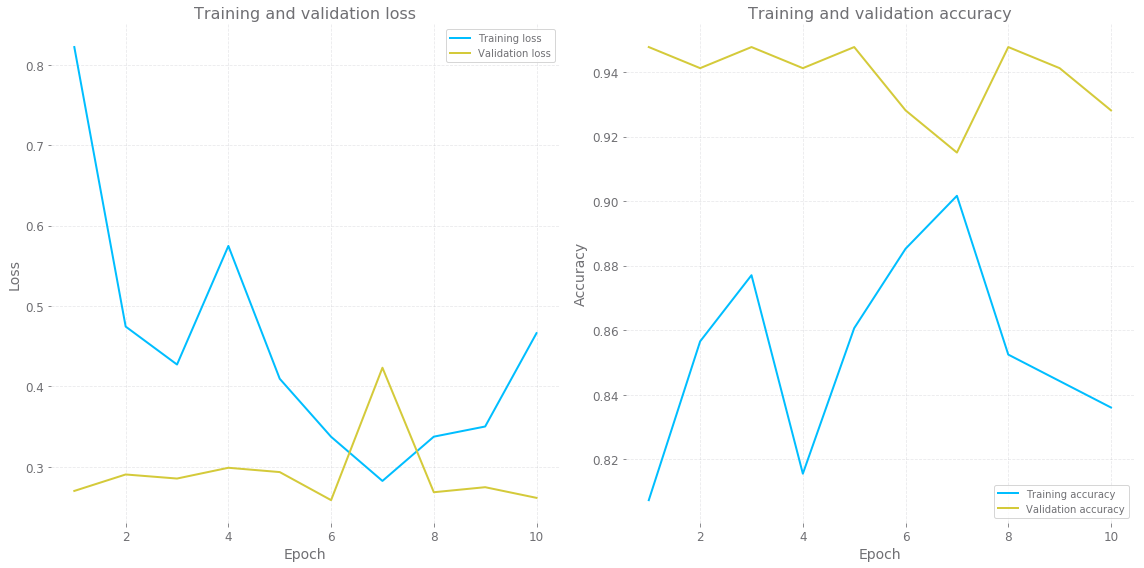

In [29]:
utils.plot_loss_and_metric(history)